In [1]:
import torch
#dataset link: https://www.robots.ox.ac.uk/~vgg/data/pets/ || https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz || https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image

In [2]:
to_tensor = [Resize((224, 224)), ToTensor()] #pre-processing

In [3]:
to_tensor

[Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn),
 ToTensor()]

In [4]:
import torchvision
from torchvision import transforms
import PIL
transforms = [
    Resize((224, 224)),
    transforms.AutoAugment(),
    ToTensor()
]

In [5]:
print(transforms)

[Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn), AutoAugment(policy=AutoAugmentPolicy.IMAGENET, fill=None), ToTensor()]


In [6]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)
        return image, target

def show_images(images, num_samples=40, cols=8):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    idx = int(len(dataset) / num_samples)
    print(images)
    for i, img in enumerate(images):
        if i % idx == 0:
            plt.subplot(int(num_samples/cols) + 1, cols, int(i/idx) + 1)
            plt.imshow(to_pil_image(img[0]))

dataset = OxfordIIITPet(root=".", download=True, transforms=Compose(to_tensor))
# show_images(dataset)


100%|██████████| 791918971/791918971 [00:24<00:00, 32605548.81it/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 16116954.00it/s]


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


In [7]:
from torchvision.models import vit_b_16

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_split = int(0.8 * len(dataset))
train, test = random_split(dataset, [train_split, len(dataset) - train_split])

train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

In [9]:
print(len(train))
print(len(test))

2944
736


In [12]:
import torch.optim as optim
from torch import nn
from torch import Tensor
import numpy as np


device = "cuda"

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.model = vit_b_16(weights='IMAGENET1K_V1')
#         for param in self.model.parameters():
#              param.requires_grad = False
#         self.model.heads = nn.Linear(768, 37)
#         self.model.heads.weight.data.normal_(mean=0.5, std=0.5)
#         self.model.heads.bias.data.zero_()
#     def forward(self, x: torch.Tensor):
#         x = self.model(x)
#         return x
loss_values = []
test_loss_values = []

model = vit_b_16(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False
model.heads = nn.Linear(768, 37)

model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.01, betas=(0.9, 0.999), weight_decay = 0.1)
criterion = nn.CrossEntropyLoss()

test_loss = 10
best_loss = 10

# #use for the test loss calculation
# epoch_losses_test = []

for epoch in range(10):
    epoch_losses = []
    model.train()
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_values.append(loss)
        loss.backward()
        optimizer.step()

        #get training loss values
        epoch_losses.append(loss.item())


        #calculating training loss
    print(f">>> Epoch {epoch} train loss: ", np.mean(epoch_losses))

    # #get the last_test_lost
    # last_test_loss = np.mean(epoch_losses_test)

    #initialize for this one
    epoch_losses_test = []

    model.eval()

    for step, (inputs, labels) in enumerate(test_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)


        #get this test lost values
        epoch_losses_test.append(loss.item())

    #calculating testloss
    test_loss = np.mean(epoch_losses_test)
    test_loss_values.append(test_loss)

    print(f">>> Epoch {epoch} test loss: ", test_loss)

    #saving files
    if(best_loss > test_loss):
          torch.save(model.state_dict(), 'best.pth')
          torch.save(model, 'model_best.pth')
          print("Model saved best ckpt")
          best_loss = test_loss

    torch.save(model.state_dict(), 'last.pth')
    torch.save(model, 'model_last.pth')
    print("Model saved last ckpt")

>>> Epoch 0 train loss:  0.6813692357391119
>>> Epoch 0 test loss:  0.49026869464179745
Model saved best ckpt
Model saved last ckpt
>>> Epoch 1 train loss:  0.18160574909542565
>>> Epoch 1 test loss:  0.3687052036757055
Model saved best ckpt
Model saved last ckpt
>>> Epoch 2 train loss:  0.07403942989691606
>>> Epoch 2 test loss:  0.36192171696735465
Model saved best ckpt
Model saved last ckpt
>>> Epoch 3 train loss:  0.06318681454285979
>>> Epoch 3 test loss:  0.40894024203652923
Model saved last ckpt
>>> Epoch 4 train loss:  0.05996150353862702
>>> Epoch 4 test loss:  0.3763840493300687
Model saved last ckpt
>>> Epoch 5 train loss:  0.029853797515186117
>>> Epoch 5 test loss:  0.36971805601016333
Model saved last ckpt
>>> Epoch 6 train loss:  0.04291840063397894
>>> Epoch 6 test loss:  0.39388992540214374
Model saved last ckpt
>>> Epoch 7 train loss:  0.029746365480367905
>>> Epoch 7 test loss:  0.3751270698140497
Model saved last ckpt
>>> Epoch 8 train loss:  0.031244856625562534
>>

In [15]:
import matplotlib.pyplot as plt
for i in range(len(loss_values)):
    loss_values[i] = loss_values[i].item()

for i in range(len(test_loss_values)):
    test_loss_values[i] = test_loss_values[i].item()


AttributeError: ignored

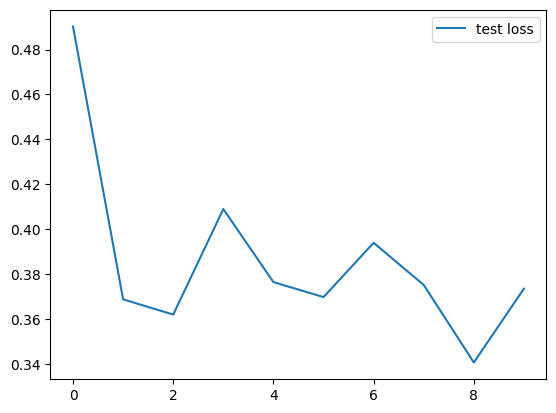

In [19]:
plt.plot(test_loss_values, label='test loss')
plt.legend()
plt.show()

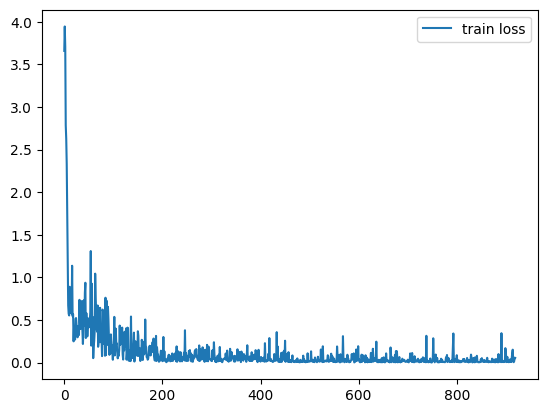

In [20]:
plt.plot(loss_values, label='train loss')
plt.legend()
plt.show()

In [21]:
model.eval()
inputs, labels = next(iter(train_dataloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)


print("Predicted classes", outputs.argmax(-1))
print("Actual classes", labels)

Predicted classes tensor([31, 27,  1,  0,  4, 36, 22,  9, 28, 35,  9,  9, 34, 16,  4, 11, 15,  0,
        30,  7, 20, 28, 18, 17, 14, 32,  1, 25, 22,  1, 16, 28],
       device='cuda:0')
Actual classes tensor([31, 27,  4,  0,  4, 36, 22,  9,  3, 35,  9,  9, 34, 16,  4, 11, 15,  0,
        30,  7, 20, 28, 18, 17, 14, 32,  1, 25, 22,  1, 16, 28],
       device='cuda:0')


In [22]:
inputs, labels = next(iter(test_dataloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)


print("Predicted classes", outputs.argmax(-1))
print("Actual classes", labels)

Predicted classes tensor([28,  6, 11, 19,  0, 25, 35, 28, 31, 32,  5, 21,  7, 24,  2, 29,  2, 28,
        26, 26, 18, 30, 12, 34, 10, 17,  6, 23, 36, 12, 21, 22],
       device='cuda:0')
Actual classes tensor([28,  6, 11, 19,  0, 25, 35, 28, 31, 32, 11, 21,  7, 24,  2, 29,  2, 28,
        26, 26, 18, 30, 12, 34, 10, 17,  6, 23, 36, 12, 21, 22],
       device='cuda:0')


In [23]:
model.load_state_dict(torch.load('best.pth'))
inputs, labels = next(iter(train_dataloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)


print("Predicted classes", outputs.argmax(-1))
print("Actual classes", labels)

Predicted classes tensor([25,  2,  7,  9, 18, 32, 25, 19,  9, 27, 22,  8, 27, 10, 12, 12, 20,  0,
         4, 36,  1, 31, 25, 12,  8, 29, 17,  8, 13, 28, 35, 12],
       device='cuda:0')
Actual classes tensor([25,  2,  7,  9, 18, 32, 25, 19,  9, 27, 22,  8, 27, 10, 12, 12, 20,  0,
         4, 36,  1, 31, 25, 12,  8, 29, 17,  8, 13, 28, 35, 12],
       device='cuda:0')


In [24]:
inputs, labels = next(iter(test_dataloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)


print("Predicted classes", outputs.argmax(-1)[0])
print("Actual classes", labels)

Predicted classes tensor(20, device='cuda:0')
Actual classes tensor([20, 36,  3, 23,  8, 31,  3, 36, 16, 10, 12, 12, 16,  0,  5, 17, 16, 18,
        29, 21, 13,  5, 29, 18, 27,  6, 29,  7, 24, 19, 23, 36],
       device='cuda:0')


In [25]:
inference = OxfordIIITPet(root=".", split='test', download=True, transforms=Compose(to_tensor))

In [26]:
print(len(inference))

3669


In [27]:
inference_dataloader = DataLoader(inference, batch_size=32, shuffle=True)

In [28]:
len(inference_dataloader)

115

In [29]:
print(labels[0])

tensor(20, device='cuda:0')


In [30]:
correct = 0
for step, (inputs, labels) in enumerate(inference_dataloader):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    length = len(labels)

    for i in range(length):
        output = outputs.argmax(-1)[i]
        label = labels[i]
        if output == label:
            correct += 1

print(f"Inference Accuracy: {correct/len(inference)}")



Inference Accuracy: 0.8988825292995366


In [31]:
inputs, labels = next(iter(inference_dataloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)

print("Predicted classes", outputs.argmax(-1))
print("Actual classes", labels)

Predicted classes tensor([ 8, 13, 23,  2, 20, 36, 25,  1, 29, 31, 22, 25, 30, 26, 26,  6, 33, 16,
         2, 18,  1,  0,  4,  3, 10,  5, 24, 10, 24,  3, 22,  3],
       device='cuda:0')
Actual classes tensor([ 8, 13, 23,  2, 20, 36, 25,  1, 29, 31, 22, 25, 30, 26, 26,  6, 33, 16,
        34, 18,  1,  0,  4,  3, 10,  5, 24, 10, 24,  3, 22,  3],
       device='cuda:0')


In [37]:
# confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []
model.to('cpu')
for step, (inputs, labels) in enumerate(inference_dataloader):
    inputs, labels = inputs.to('cpu'), labels.to('cpu')
    outputs = model(inputs)
    length = len(labels)

    for i in range(length):
        output = outputs.argmax(-1)[i]
        label = labels[i]
        y_pred.append(output)
        y_true.append(label)

cm = confusion_matrix(y_true, y_pred)

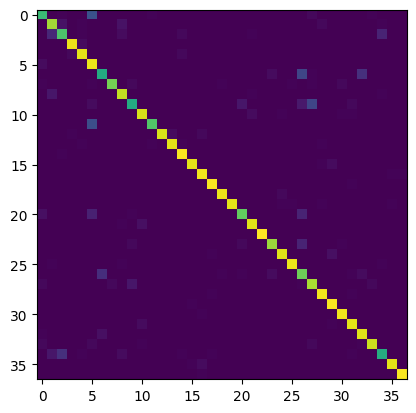

In [40]:
plt.imshow(confusion_matrix(y_true, y_pred))
